In [28]:
import numpy as np
import time

def puf_query(c, w):
    n = c.shape[1]
    phi = np.ones(n+1)
    phi[n] = 1
    for i in range(n-1, -1, -1):
        phi[i] = (2*c[0,i]-1)*phi[i+1]

    r = (np.dot(phi, w) > 0)
    return r
    
# Problem Setup
target = 0.99  # The desired prediction rate
n = 64  # number of stages in the PUF

# Initialize the PUF
np.random.seed(int(time.time()))
data = np.loadtxt('weight_diff.txt')
w = np.zeros((n+1, 1))
for i in range(1, n+2):
    randi_offset = np.random.randint(1, 45481)
    w[i-1] = data[randi_offset-1]

# Syntax to query the PUF:
c = np.random.randint(0, 2, size=(1, n))  # a random challenge vector
r = puf_query(c, w)
# you may remove these two lines

# You can use the puf_query function to generate your training dataset
# ADD YOUR DATASET GENERATION CODE HERE
training_size = 10000
X_train = []
y_train = []

for i in range(training_size):
  c = np.random.randint(0, 2, size=(1, n))
  r = puf_query(c, w)

  X_train.append(c)
  y_train.append(r)

X_train, y_train = np.array(X_train), np.array(y_train)
w0 = np.zeros((n+1, 1))  # The estimated value of w.
# Try to estimate the value of w here. This section will be timed. You are
# allowed to use the puf_query function here too, but it will count towards
# the training time.
t0 = time.process_time()
# ADD YOUR TRAINING CODE HERE


t1 = time.process_time()
training_time = t1 - t0  # time taken to get w0
print("Training time:", training_time)
print("Training size:", training_size)

# Evaluate your result
n_test = 10000
correct = 0
for i in range(1, n_test+1):
    c_test = np.random.randint(0, 2, size=(1, n))  # a random challenge vector
    r = puf_query(c_test, w)
    r0 = puf_query(c_test, w0)
    correct += (r==r0)

success_rate = correct/n_test
print("Success rate:", success_rate)

# If the success rate is less than 99%, a penalty time will be added
# One second is add for each 0.01% below 99%.
effective_training_time = training_time
if success_rate < 0.99:
    effective_training_time = training_time + 10000*(0.99-success_rate)
print("Effective training time:", effective_training_time)





Training time: 3.633400000069287e-05
Training size: 10000
Success rate: [0.4515]
Effective training time: [5385.00003633]


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.a1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.a2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.a1(out)
        out = self.fc2(out)
        out = self.a2(out)
        out = self.fc3(out)
        return out


model = Net()
print(model)

Net(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (a1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (a2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Data(X_test, y_test)
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

learning_rate = 0.1

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [43]:
num_epochs = 1000
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        print(loss.item())

print("Training Complete")

Streaming output truncated to the last 5000 lines.
0.00022679728863295168
0.00018704659305512905
0.00019369274377822876
0.000245825998717919
0.0002225196803919971
0.0001805004576453939
0.00024750627926550806
0.00024221703642979264
0.00027593033155426383
0.000213124934816733
0.0001112157478928566
0.00018500065198168159
0.00018921471200883389
0.0001601112016942352
0.00014764185470994562
0.00018647211254574358
0.00022257781529333442
0.00022739777341485023
0.00012692020391114056
0.00013705596211366355
0.00024561939062550664
0.00029398518381640315
0.00020588526967912912
0.000145094032632187
0.00020978483371436596
0.00021099590230733156
0.0002036581572610885
0.0002504846197552979
0.00023574392253067344
0.00018494929827284068
0.00014138473488856107
0.00023644133761990815
0.0001714883983368054
0.00013764365576207638
0.00018086688942275941
0.00017630541697144508
9.988994861487299e-05
0.00028015198768116534
0.00026913953479379416
0.00022237692610360682
0.00020337107707746327
0.000193358137039467

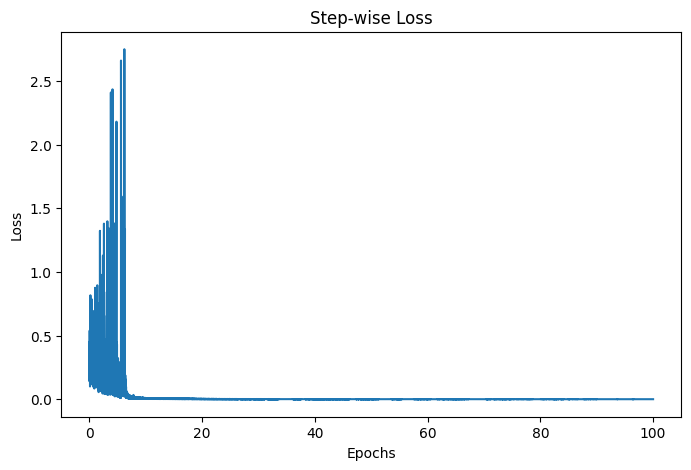

In [45]:
import matplotlib.pyplot as plt

step = np.linspace(0, 100, 157000)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [51]:
model.eval()

correct = 0
with torch.no_grad():
  for i in range(1, n_test+1):
      c_test = np.random.randint(0, 2, size=(1, n))  # a random challenge vector
      r = puf_query(c_test, w)
      c_test = torch.from_numpy(c_test.astype(np.float32))
      r0 = int(model(c_test) > 0)
      correct += (r==r0)

In [52]:
correct

array([5177])